# Problem at the 180/-180° longitude limit
For colocalisation around the 180/-180 limit, we change the longitudes coordinates system from -180-180° to 0-360°

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.wind as wind


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=14, processes=14) # a tester
    w = cluster.scale(jobs=5)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.252:8787/status,
Dashboard: http://10.148.0.252:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.252:46551,Workers: 0
Dashboard: http://10.148.0.252:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
l = cstes.labels[1]
ds_data = xr.open_zarr(cstes.zarr_dir+'/'+l+'.zarr').persist()

### Conversion functions (to move to cstes.py)

In [4]:
lon_180_to_360 = lambda lon : lon % 360
lon_360_to_180 = lambda lon :(lon + 180) % 360 - 180

In [9]:
lon_180_to_360(-25)

335

In [6]:
lon_360_to_180(345)

-15

### Select a colocalisation at the 180/-180 limit

In [10]:
ds_obs = ds_data.where(ds_data.box_lonc==ds_data.box_lonc.max(), drop=True).isel(obs=0)
dt=(-1,2)
ds_obs

<xarray.Dataset>
Dimensions:                        (site_obs: 1489, alti_time: 21, box_y: 40,
                                    box_x: 80, alti_time_mid: 20)
Coordinates: (12/19)
    alti_lat                       (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                       (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                      (alti_time) int64 0 1 2 3 4 ... 17 18 19 20
    alti_time_                     (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                  (alti_time_mid) float64 0.5 1.5 ... 18.5 19.5
    alti_x                         (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                             ...
    drifter_time                   (site_obs) datetime64[ns] dask.array<chunksize=(94,), meta=np.ndarray>
    drifter_x                      (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_y                      (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    lat                            float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                            float64 dask.array<chunksize=(), meta=np.ndarray>
    time                           datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: site_obs
Data variables: (12/61)
    __site_id                      object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice          float64 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                    object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                          (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_y                          (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    alti___distance                float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                             ...
    drifter_vn                     (site_obs) float32 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vx                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    drifter_vy                     (site_obs) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    f                              float64 dask.array<chunksize=(), meta=np.ndarray>
    g_grad_sla                     (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    g_grad_sla_denoised            (alti_time_mid) float64 dask.array<chunksize=(20,), meta=np.ndarray>
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2019-01-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [11]:
box_dim = float( 1.5*ds_obs.box_x.max()*1e-3/111/np.cos(2*np.pi*ds_obs.box_latc/360) ) # *
limite_lon = ds_obs.box_lonc.values > 180-box_dim or ds_obs.box_lonc.values < -(180-box_dim) 

In [12]:
box_dim

4.153529098627901

In [13]:
limite_lon

True

In [16]:
def get_aviso_obs(ds_obs, dt, limite=True):#just to show the difference and verify
    # load data

    avis0 = aviso.load_aviso(ds_obs.time.values, dt, suffix="aviso_")# aviso for matchup time
    
    # -180-180 longitude problem (paragraph added to aviso_lib functions)
    
    box_dim = 180-1.5*ds_obs.box_x.max()*1e-3/111*np.cos(2*np.pi*ds_obs.box_latc/360).values
    limite_lon = ds_obs.box_lonc.values > 180-box_dim or ds_obs.box_lonc.values < -(180-box_dim) 

    if limite and limite_lon :
        avis0['aviso_lon'] = xr.apply_ufunc(lon_180_to_360, avis0.aviso_lon.compute())#compute for apply_ufunc
        box_lon = xr.apply_ufunc( lon_180_to_360, ds_obs.box_lon.compute())
        avis0 = avis0.sortby('aviso_lon') # sort aviso variables, ds_obs already sorted according to box_x, so no need to re-sort
    else : 
        box_lon = ds_obs.box_lon#.compute()
        
    # interpolate on local grid

    sla = avis0.sla.interp(aviso_lon=box_lon, aviso_lat=ds_obs.box_lat,)


    """
    err_sla = aviso.err_sla.interp(aviso_lon=ds_obs.box_lon,
                           aviso_lat=ds_obs.box_lat,
                          )
    """    
    # convert to dataset and massage in order to concatenate properly in get_aviso
    #ds = sla.to_dataset()
    ds = xr.Dataset()
    ds['aviso_sla'] = sla
    ds = ds.drop("time")
    ds["aviso_dates"] = ds.aviso_time
    ds['time']=xr.DataArray(ds_obs.time.values)
    
    
    #compute g_grad
    g=9.81
    ds['aviso_g_grad_x'] = g * ds.aviso_sla.differentiate('box_x')
    ds['aviso_g_grad_y'] = g * ds.aviso_sla.differentiate('box_y')
      
    # matchup site drifter/sat
    ds_matchup = ds_obs.isel(site_obs=int(ds_obs.__site_matchup_indice),#.compute()),
                             alti_time=10, alti_time_mid=10)
    
    
    ds['aviso_drifter_matchup_sla'] = ds.aviso_sla.interp(box_x = ds_matchup.drifter_x.values,
                                                           box_y = ds_matchup.drifter_y.values,
                                                          aviso_time = ds_matchup.drifter_time.values
                                                         )
    ds['aviso_drifter_matchup_g_grad_x'] = ds.aviso_g_grad_x.interp(box_x = ds_matchup.drifter_x.values,
                                                                     box_y = ds_matchup.drifter_y.values,
                                                                     aviso_time = ds_matchup.drifter_time.values
                                                                    )
    ds['aviso_drifter_matchup_g_grad_y'] = ds.aviso_g_grad_y.interp(box_x = ds_matchup.drifter_x.values,
                                                                     box_y = ds_matchup.drifter_y.values,
                                                                    aviso_time = ds_matchup.drifter_time.values
                                                                    )
    ds['aviso_alti_matchup_sla'] = ds.aviso_sla.interp(box_x = ds_matchup.alti_x.values,
                                                        box_y =ds_matchup.alti_y.values,
                                                       aviso_time = ds_matchup.alti_time_.values
                                                       )
    ds['aviso_alti_matchup_g_grad_x'] = ds.aviso_g_grad_x.interp(box_x = ds_matchup.alti_x.values,
                                                                  box_y =ds_matchup.alti_y.values,
                                                                 aviso_time = ds_matchup.alti_time_.values
                                                                 )
    ds['aviso_alti_matchup_g_grad_y'] = ds.aviso_g_grad_y.interp(box_x = ds_matchup.alti_x.values,
                                                                  box_y =ds_matchup.alti_y.values,
                                                                  aviso_time = ds_matchup.alti_time_.values
                                                                 )
    ds = (ds.drop(["aviso_time", "lon", "lat", "aviso_lon", "aviso_lat"])#"time", # forget about actual dates in time coordinate
   )#.rename(sla="aviso_sla")
    
    ds = ds.assign_coords({"aviso_time":[_dt for _dt in range(*dt)] })
    ds.aviso_time.attrs = {'description' : 'delta time from the matchup time, 0 is the matchup time indice on aviso_time dimension', 'units':'days'}


    return ds

In [18]:
ds_180 = get_aviso_obs(ds_obs, dt, limite=False)
ds_360 = get_aviso_obs(ds_obs, dt, limite=True)
ds_360

<xarray.Dataset>
Dimensions:                         (box_x: 80, box_y: 40, aviso_time: 3)
Coordinates:
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
  * aviso_time                      (aviso_time) int64 -1 0 1
Data variables:
    aviso_sla                       (aviso_time, box_y, box_x) float64 0.0726...
    aviso_dates                     (aviso_time) datetime64[ns] 2018-03-01 .....
    time                            datetime64[ns] 2018-03-02T09:00:00
    aviso_g_grad_x                  (aviso_time, box_y, box_x) float64 -1.984...
    aviso_g_grad_y                  (aviso_time, box_y, box_x) float64 -2.188...
    aviso_drifter_matchup_sla       float64 0.07075
    aviso_drifter_matchup_g_grad_x  float64 1.567e-06
    aviso_drifter_matchup_g_grad_y  float64 -8.514e-07
    aviso_alti_matchup_sla          float64 0.1009
    aviso_alti_matchup_g_grad_x     float64 2.093e-06
    aviso_alti_matchup_g_grad_y     float64 8.69e-07

Nan values at matchup site due to the 180/-180° limit

In [18]:
ds_360

<xarray.Dataset>
Dimensions:                         (box_x: 80, box_y: 40, aviso_time: 3)
Coordinates:
  * box_x                           (box_x) float64 -2e+05 ... 1.95e+05
  * box_y                           (box_y) float64 -1e+05 -9.5e+04 ... 9.5e+04
  * aviso_time                      (aviso_time) int64 -1 0 1
Data variables:
    aviso_sla                       (aviso_time, box_y, box_x) float64 0.0726...
    aviso_dates                     (aviso_time) datetime64[ns] 2018-03-01 .....
    time                            datetime64[ns] 2018-03-02T09:00:00
    aviso_g_grad_x                  (aviso_time, box_y, box_x) float64 -1.984...
    aviso_g_grad_y                  (aviso_time, box_y, box_x) float64 -2.188...
    aviso_drifter_matchup_sla       float64 0.07075
    aviso_drifter_matchup_g_grad_x  float64 1.567e-06
    aviso_drifter_matchup_g_grad_y  float64 -8.514e-07
    aviso_alti_matchup_sla          float64 0.1009
    aviso_alti_matchup_g_grad_x     float64 2.093e-06
    aviso_alti_matchup_g_grad_y     float64 8.69e-07

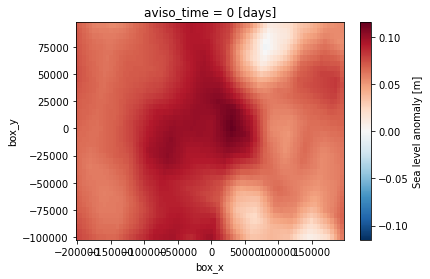

In [16]:
ds_360.sel(aviso_time=0).aviso_sla.plot()

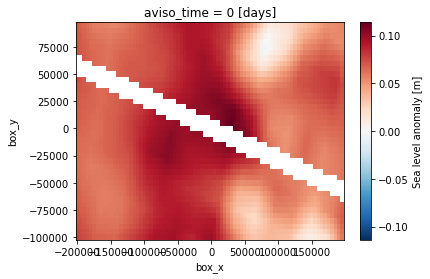

In [17]:
ds_180.sel(aviso_time=0).aviso_sla.plot()

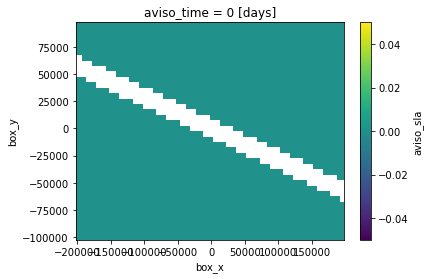

In [19]:
(ds_360.sel(aviso_time=0).aviso_sla-ds_180.sel(aviso_time=0).aviso_sla).plot()

In [14]:
cluster.close()